In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d gatewayadam/cars-and-tanks-image-classification

Dataset URL: https://www.kaggle.com/datasets/gatewayadam/cars-and-tanks-image-classification
License(s): CC0-1.0
 93% 49.0M/52.4M [00:00<00:00, 96.1MB/s]
100% 52.4M/52.4M [00:00<00:00, 93.6MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/cars-and-tanks-image-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/cars-and-tanks-image-classification.zip' mode='r'>>

In [ ]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
def load_images_from_folder(folder, label, image_size=(256, 256)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith(('.png', '.jpg', '.jpeg')):  # Add any other extensions if necessary
            img = Image.open(img_path).convert('RGB')  # Convert image to RGB
            img = img.resize(image_size)
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label)
    return images, labels

In [ ]:
cars_train_images,cars_train_labels  = load_images_from_folder('/content/cars_tanks/train/cars', 0)
tanks_train_images, tanks_train_labels = load_images_from_folder('/content/cars_tanks/train/tanks', 1)

In [ ]:
x_train = np.array(cars_train_images+ tanks_train_images)
y_train = np.array(cars_train_labels + tanks_train_labels)

In [ ]:
cars_test_images, cars_test_labels = load_images_from_folder('/content/cars_tanks/test/cars', 0)
tanks_test_images, tanks_test_labels = load_images_from_folder('/content/cars_tanks/test/tanks', 1)

x_test = np.array(cars_test_images + tanks_test_images)
y_test = np.array(cars_test_labels + tanks_test_labels)

Shape of X_train:  (1303, 256, 256, 3)
Shape of Y_train:  (1303,)
Shape of X_test:  (200, 256, 256, 3)
Shape of Y_test:  (200,)


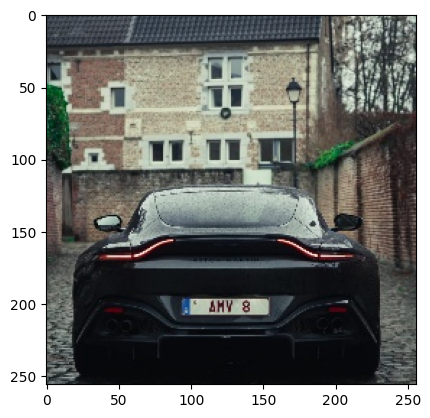

In [ ]:
train_indices = np.arange(x_train.shape[0])
np.random.shuffle(train_indices)
x_train = x_train[train_indices]
y_train = y_train[train_indices]

test_indices = np.arange(x_test.shape[0])
np.random.shuffle(test_indices)
x_test = x_test[test_indices]
y_test = y_test[test_indices]

x_train = x_train / 255.0
x_test = x_test / 255.0

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

print("Shape of X_train: ", x_train.shape)
print("Shape of Y_train: ", y_train.shape)
print("Shape of X_test: ", x_test.shape)
print("Shape of Y_test: ", y_test.shape)

idx = random.randint(0, len(x_train))
plt.imshow(x_train[idx, :])
plt.show()

In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [ ]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, reduce_lr])


Epoch 1/50
21/21 [==============================] - 23s 1s/step - loss: 0.7903 - accuracy: 0.8066 - val_loss: 1.2615 - val_accuracy: 0.5000 - lr: 4.0000e-05
Epoch 2/50
21/21 [==============================] - 19s 921ms/step - loss: 1.1888 - accuracy: 0.8219 - val_loss: 1.1809 - val_accuracy: 0.5100 - lr: 4.0000e-05
Epoch 3/50
21/21 [==============================] - 21s 993ms/step - loss: 1.6173 - accuracy: 0.8158 - val_loss: 1.2692 - val_accuracy: 0.5050 - lr: 4.0000e-05
Epoch 4/50
21/21 [==============================] - 19s 899ms/step - loss: 1.3802 - accuracy: 0.8258 - val_loss: 1.2628 - val_accuracy: 0.5200 - lr: 4.0000e-05
Epoch 5/50
21/21 [==============================] - 21s 978ms/step - loss: 0.7961 - accuracy: 0.8350 - val_loss: 1.2439 - val_accuracy: 0.5250 - lr: 4.0000e-05
Epoch 6/50
21/21 [==============================] - 20s 935ms/step - loss: 0.9904 - accuracy: 0.8250 - val_loss: 1.0760 - val_accuracy: 0.5550 - lr: 1.0000e-05
Epoch 7/50
21/21 [=========================

In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print("\nTest accuracy:", test_acc)

7/7 - 0s - loss: 0.3971 - accuracy: 0.8500 - 246ms/epoch - 35ms/step

Test accuracy: 0.8500000238418579


1/1 [==============================] - 0s 19ms/step


Text(0.5, 1.0, 'Actual: cars Predicted: cars')

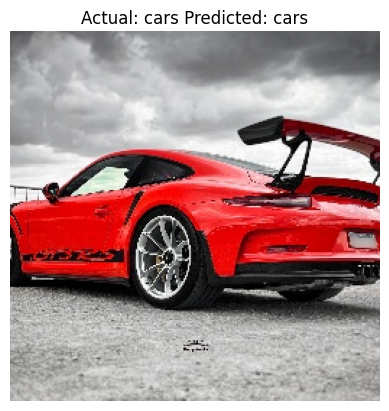

In [ ]:
# # Visualize a random test image
# idx = random.randint(0, len(x_test)-1)
# plt.imshow(x_test[idx])
# plt.axis('off')
# plt.title('Actual: {} Predicted: {:.2f}%'.format('tanks' if y_test[idx]==0.5 else 'cars', model.predict(np.expand_dims(x_test[idx], axis=0))[0][0]*100))
# plt.show()

import random
import numpy as np
import matplotlib.pyplot as plt

# Assume x_test, y_test, and model are already defined
# Select a random test image
idx = random.randint(0, len(x_test) - 1)
image = x_test[idx]

# Predict the class
prediction = model.predict(np.expand_dims(image, axis=0))[0][0]
predicted_class = 'tanks' if prediction >= 0.5 else 'cars'

# Get the actual class
actual_class = 'tanks' if y_test[idx] == 1 else 'cars'

# Plot the image with actual and predicted class names
plt.imshow(image)
plt.axis('off')
plt.title(f'Actual: {actual_class} Predicted: {predicted_class}')
# plt.show()


In [ ]:
# Classification report and confusion matrix
y_pred = (model.predict(x_test) > 0.5).astype("int32")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

7/7 [==============================] - 0s 32ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       100
           1       0.81      0.92      0.86       100

    accuracy                           0.85       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200



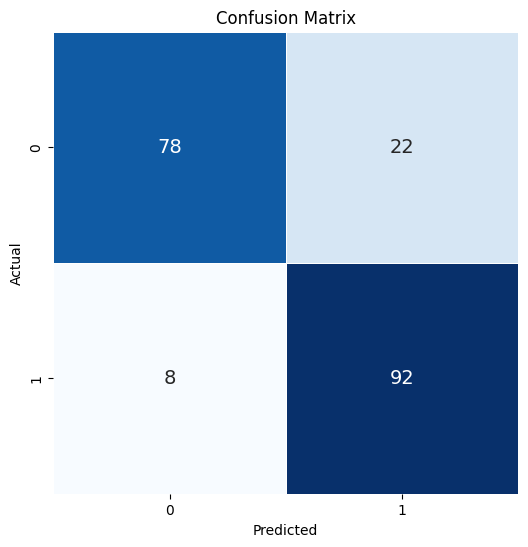

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 14}, linewidths=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


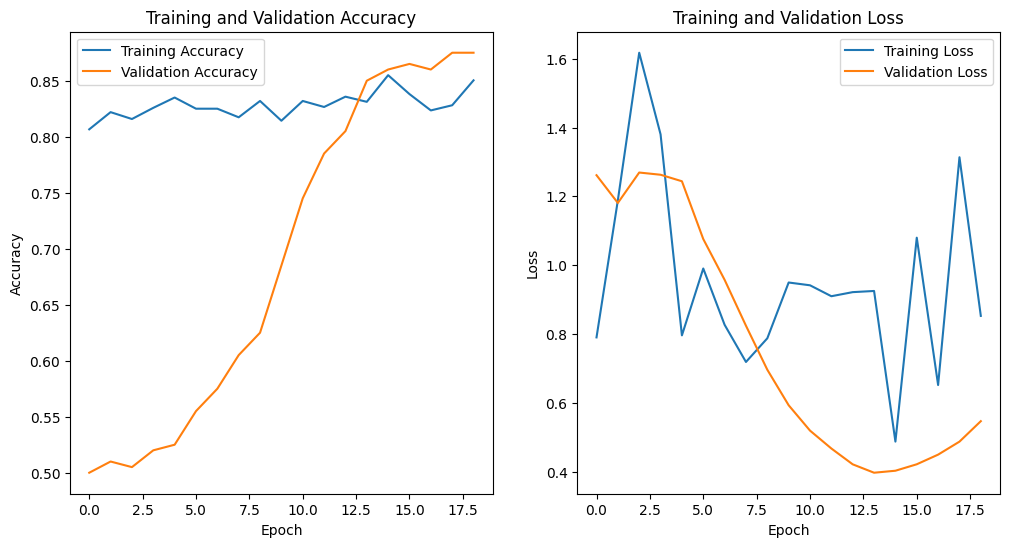

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()